In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model


In [2]:
# Replace with your external test file path
external_test_path = 'test_set_with_features.csv'
test_df = pd.read_csv(external_test_path)
test_df.head()


,Translation,Core_Emotion,Tokens,POS_Tags_new,Sentiment_Score_new,GloVe_Embedding_new
0,Sofia. Lilyana Georgieva and her 13-year-old d...,neutral,"['sofia', '.', 'lilyana', 'georgieva', 'and', ...","['PROPN', 'PUNCT', 'PROPN', 'PROPN', 'CCONJ', ...",0.0000,"[0.020633583888411522, 0.20872867107391357, 0...."
1,Ever since Velina's father abandoned her famil...,sadness,"['ever', 'since', 'velina', ""'s"", 'father', 'a...","['ADV', 'SCONJ', 'PROPN', 'PART', 'NOUN', 'VER...",-0.4588,"[0.03035452589392662, 0.15139038860797882, -0...."
2,There is almost no desire that Liliana does no...,happiness,"['there', 'is', 'almost', 'no', 'desire', 'tha...","['PRON', 'VERB', 'ADV', 'DET', 'NOUN', 'PRON',...",-0.2243,"[0.016226692125201225, 0.18178969621658325, -0..."
3,Velina has a very difficult time to make a sta...,sadness,"['velina', 'has', 'a', 'very', 'difficult', 't...","['PROPN', 'VERB', 'DET', 'ADV', 'ADJ', 'NOUN',...",-0.3604,"[0.02610410377383232, 0.20006246864795685, -0...."
4,So I allowed myself to buy her whatever she wa...,neutral,"['so', 'i', 'allowed', 'myself', 'to', 'buy', ...","['ADV', 'PRON', 'VERB', 'PRON', 'PART', 'VERB'...",0.0000,"[0.03702537342905998, 0.15453578531742096, -0...."


In [3]:
file_path = 'processed_dataset_v3.csv'
df = pd.read_csv(file_path)

In [6]:
# Print unique labels to inspect
print("Unique emotion labels before filtering:", test_df['Core_Emotion'].unique())

# Remove rows where the emotion is "core" or NaN
test_df = test_df[test_df['Core_Emotion'].notna()]  # Drop NaNs
test_df = test_df[test_df['Core_Emotion'].str.lower() != 'core']  # Remove 'core'

# Re-check the labels
print("Unique emotion labels after filtering:", test_df['Core_Emotion'].unique())


Unique emotion labels before filtering: ['neutral' 'sadness' 'happiness' 'anger' 'fear' 'surprise' 'disgust']
Unique emotion labels after filtering: ['neutral' 'sadness' 'happiness' 'anger' 'fear' 'surprise' 'disgust']


In [7]:
test_df.shape

(941, 6)

In [15]:
import ast

# Convert list-like token strings into clean text
def safe_tokens_to_str(x):
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except:
            return ""
    if isinstance(x, list):
        return ' '.join(x)
    return ""

# Apply to training set
df['Tokens_str'] = df['Tokens'].apply(safe_tokens_to_str)


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Tokens_str'])


In [17]:
# Convert the test token strings to sequences
sequences = tokenizer.texts_to_sequences(test_df['Tokens_str'])

# Pad sequences to match training input length
MAX_SEQUENCE_LENGTH = 50  # must match what was used during training
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


In [18]:
from sklearn.preprocessing import LabelEncoder

# Convert stringified POS tags in training data to lists
df['POS_Tags_new'] = df['POS_Tags_new'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of all tags
all_tags = [tag for seq in df['POS_Tags_new'] for tag in seq]

# Fit label encoder
le_pos = LabelEncoder()
le_pos.fit(all_tags)


LabelEncoder()

In [19]:
# Convert POS_Tags_new to lists
test_df['POS_Tags_new'] = test_df['POS_Tags_new'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Encode POS tags using the trained LabelEncoder
test_df['POS_Encoded'] = test_df['POS_Tags_new'].apply(lambda tags: le_pos.transform(tags))

# Pad to match the input shape expected by the model
pos_padded = pad_sequences(test_df['POS_Encoded'], maxlen=MAX_SEQUENCE_LENGTH, padding='post')


In [20]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on training sentiment scores
scaler = StandardScaler()
scaler.fit(df[['Sentiment_Score_new']])


StandardScaler()

In [21]:
# Transform sentiment scores in test set
sentiment_scaled = scaler.transform(test_df[['Sentiment_Score_new']])


In [22]:
# Convert GloVe embeddings from string to numpy arrays
test_df['GloVe_Embedding_new'] = test_df['GloVe_Embedding_new'].apply(
    lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.zeros(300)
)

# Stack into a 2D array
glove_features = np.vstack(test_df['GloVe_Embedding_new'].values)


In [23]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# Redefine custom metric
def f1_micro(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# Load model
model = load_model("LSTM_model_6.h5", custom_objects={'f1_micro': f1_micro})


In [24]:
import numpy as np

# Predict probabilities
pred_probs = model.predict({
    'text_input': padded_sequences,
    'sentiment_input': sentiment_scaled,
    'pos_input': pos_padded,
    'glove_input': glove_features
})

# Convert predicted probabilities to class indices
pred_classes = np.argmax(pred_probs, axis=1)


30/30 [==============================] - 6s 13ms/step


In [26]:
from sklearn.preprocessing import LabelEncoder

# Recreate and fit label encoder from training emotion labels
label_encoder = LabelEncoder()
label_encoder.fit(df['emotion'])  # assumes df['emotion'] contains original labels

# Decode predictions
pred_labels = label_encoder.inverse_transform(pred_classes)

# Add predictions to test_df for inspection
test_df['Predicted_Emotion'] = pred_labels
test_df[['Tokens_str', 'Core_Emotion', 'Predicted_Emotion']].head()


,Tokens_str,Core_Emotion,Predicted_Emotion
0,sofia . lilyana georgieva and her 13 - year - ...,neutral,sadness
1,ever since velina 's father abandoned her fami...,sadness,neutral
2,there is almost no desire that liliana does no...,happiness,anger
3,velina has a very difficult time to make a sta...,sadness,neutral
4,so i allowed myself to buy her whatever she wa...,neutral,sadness


<Figure size 1000x800 with 0 Axes>

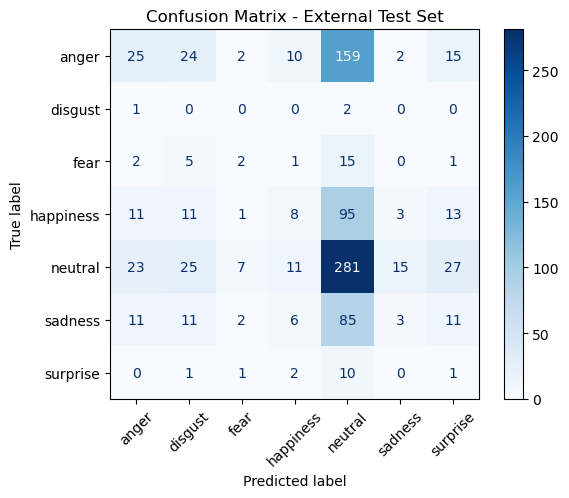

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get true labels (encoded)
true_labels = label_encoder.transform(test_df['Core_Emotion'])

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_classes)

# Plot it
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix - External Test Set")
plt.show()


In [29]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, pred_classes, target_names=label_encoder.classes_)

# Print it
print("📊 Classification Report:\n")
print(report)


📊 Classification Report:

              precision    recall  f1-score   support

       anger       0.34      0.11      0.16       237
     disgust       0.00      0.00      0.00         3
        fear       0.13      0.08      0.10        26
   happiness       0.21      0.06      0.09       142
     neutral       0.43      0.72      0.54       389
     sadness       0.13      0.02      0.04       129
    surprise       0.01      0.07      0.02        15

    accuracy                           0.34       941
   macro avg       0.18      0.15      0.14       941
weighted avg       0.32      0.34      0.29       941

